<a href="https://colab.research.google.com/github/theRuchiChauhan/WSI-analysis/blob/master/fetal_head_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation of fetal head from ultrasound images
---

During pregnancy, the head circumference of the fetus is measured as a quick, noninvasive method to determine if there's a potential problem or if something needs to be monitored. For example, if the head grows too fast, it could sign *hydrocephalus* or water in the brain. If the head grows too slowly, it could be a sign of *microcephaly* or a smaller head than normal.

This important biometric is mesured during the ultrasound. While there are computer aided tools for manual measurements on the monitor, there is a required expertise, subjectivity, and room for error. Automated segmentation of fetus head can give quick quantifications relieving the radiologist for other important tasks and decisions.  

That's what we will do here! The dataset used for this task can be found at [HC-18 challenge](https://hc18.grand-challenge.org/).

## Obtaining data & setting up requirements

In [1]:
# Connect data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! pwd
! mkdir us_dataset
! tar -xzf /content/gdrive/MyDrive/us_data.tar.gz -C us_dataset

/content


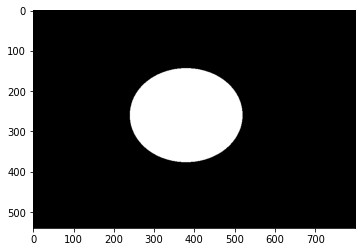

In [34]:
from PIL import Image
im = Image.open('us_dataset/all_masks/151_HC_mask.png')
# im.show()

plt.imshow(np.array(im))

In [4]:
# # Obtain U-Net code by Meet Shah
# ! git clone https://github.com/meetps/pytorch-semseg

Cloning into 'pytorch-semseg'...
remote: Enumerating objects: 1088, done.
remote: Total 1088 (delta 0), reused 0 (delta 0), pack-reused 1088
Receiving objects: 100% (1088/1088), 277.47 KiB | 1.13 MiB/s, done.
Resolving deltas: 100% (738/738), done.


**MODEL**

In [35]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from kornia.losses import dice_loss
from kornia.utils import one_hot
# from ptsemseg.models.unet import unet

In [36]:
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm):
        super(unetConv2, self).__init__()

        if is_batchnorm:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, 3, 1, 0), nn.BatchNorm2d(out_size), nn.ReLU()
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, 3, 1, 0), nn.BatchNorm2d(out_size), nn.ReLU()
            )
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 0), nn.ReLU())
            self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, 3, 1, 0), nn.ReLU())

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        return outputs


class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv):
        super(unetUp, self).__init__()
        self.conv = unetConv2(in_size, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        offset = outputs2.size()[2] - inputs1.size()[2]
        padding = 2 * [offset // 2, offset // 2]
        outputs1 = F.pad(inputs1, padding)
        return self.conv(torch.cat([outputs1, outputs2], 1))


class unet(nn.Module):
    def __init__(
        self, feature_scale=4, n_classes=21, is_deconv=True, in_channels=3, is_batchnorm=True
    ):
        super(unet, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv)
        self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv)
        self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv)
        self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv)

        # final conv (without any concat)
        self.final = nn.Conv2d(filters[0], n_classes, 1)

    def forward(self, inputs):
        conv1 = self.conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)

        center = self.center(maxpool4)
        up4 = self.up_concat4(conv4, center)
        up3 = self.up_concat3(conv3, up4)
        up2 = self.up_concat2(conv2, up3)
        up1 = self.up_concat1(conv1, up2)

        final = self.final(up1)

        return final

In [5]:
# # rearrange files for easy access
# ! mv pytorch-semseg/ptsemseg .

In [6]:
# Install kornia, a useful library that does a lot of operations on PyTorch tensors
! pip install kornia

     |████████████████████████████████| 303 kB 8.3 MB/s 


## Dataloader

In [37]:
class ImageLoader(Dataset):
  """ Data loader class """

  def __init__(self, path, file_list, aug_list=None, aug_prob=None):
    """
    Args:
      path (str): path where images stored
      file_list (List[str]): list of images in current split
      aug_list (List[str]): list of torchvision transforms
      aug_prob (float): Probability of applying random aug (if aug_list != None)
    """
    self.path = path
    self.file_list = file_list
    self.aug_list = aug_list
    self.aug_prob = aug_prob

  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, idx):
    """ Preprocess and return a single sample & label """
    img_name = os.path.join(self.path, 'all_images', self.file_list[idx])
    mask_fname = self.file_list[idx].split('.')[0] + '_mask.png'
    mask_name = os.path.join(self.path, 'all_masks', mask_fname)
    img = Image.open(img_name)
    mask = Image.open(mask_name)

    # Resize to dimensions supported by Vanilla UNet
    img = img.resize((572, 572), Image.LANCZOS)
    mask = mask.resize((388, 388), Image.NEAREST)

    img = np.array(img)
    mask = np.array(mask)
    mask[mask == 255] = 1

    mask = torch.Tensor([mask])

    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  
    img = torch.Tensor(img)
    img = img.permute(2, 0, 1)

    # select and apply random augmentation (if passed)
    if self.aug_list:
      do_aug = np.random.choice([True, False], 1, p=[self.aug_prob,
                                                     1-self.aug_prob])
      if do_aug:
        aug_name = np.random.choice(self.aug_list, 1)
        img = aug_name[0](img)
    img = (img - torch.mean(img)) / torch.std(img)
    return img, mask

In [38]:
def get_data_loaders(categories, path, file_lists,
                     augment, aug_prob, batch_size):
  """
  Wrapper function to return dataloader(s)
  Args:
    categories (List[str]): names of processes for which dataloader needed
    path (str): path where images stored
    file_lists (List[List[str]]): list of file lists
    augment (boolean): whether to apply augmentation
    aug_prob (float): Probability of applying random aug
    batch_size (int): batch size
  Returns:
    torch.utils.data.DataLoader object
  """
  loaders = []
  for i, category in enumerate(categories):
    if category == 'train' and augment:
      aug_list = [
          transforms.RandomAffine(0, translate=(0.2, 0.2)),
          transforms.RandomHorizontalFlip(p=1),
          transforms.RandomRotation(degrees=(-10, 10), fill=(0,)),
          transforms.GaussianBlur((17, 17), (11, 11))
      ]
    else:
      aug_list = None
    loader = DataLoader(
        ImageLoader(path, file_lists[i], aug_list, aug_prob),
        batch_size,
        num_workers=1
        )
    loaders.append(loader)
  return loaders

## Train/val/test loop

In [39]:
# dice score
def integral_dice(pred, gt, k):
    '''
    Dice coefficient for multiclass hard thresholded prediction consisting of integers instead of binary
    values. k = integer for class for which Dice is being calculated.
    '''
    return (torch.sum(pred[gt == k] == k)*2.0
            / (torch.sum(pred[pred == k] == k)
               + torch.sum(gt[gt == k] == k)).float())

In [40]:
def learn(model, loader, optimizer, process):
  """ main function for single epoch of train, val or test """
  dice_list = []
  running_loss = 0
  num_batches = len(loader)
  with trange(num_batches, desc=process, ncols=100) as t:
    for batch_num, sample in enumerate(loader):
      img_batch, masks = sample
      masks = masks[:, 0, :, :, 0].long()
      # one hot encoding labels
      masks_oh = one_hot(masks, num_classes=2, device='cpu', dtype=masks.dtype)
      if process == 'train':
        model.train()
        optimizer.zero_grad()
        preds = F.softmax(model(img_batch.cuda()), 1)
        loss = F.binary_cross_entropy(preds, masks_oh.cuda())
        # loss = dice_loss(preds, masks.cuda())
        loss.backward()
        optimizer.step()
      else:
        model.eval()
        with torch.no_grad():
          preds = F.softmax(model(img_batch.cuda()), 1)
          loss = F.binary_cross_entropy(preds, masks_oh.cuda())
          # loss = dice_loss(preds, masks.cuda())
      hard_preds = torch.argmax(preds, 1)
      dice = integral_dice(hard_preds, masks, 1)
      dice_list.append(dice.item())
      running_loss += loss  
      t.set_postfix(loss=running_loss.item()/(float(batch_num+1)*batch_size))
      t.update()
  mean_dice = np.mean(np.array(dice_list))
  final_loss = running_loss.item()/(num_batches*batch_size)
  return mean_dice, final_loss

In [12]:
def get_splits(all_names, train_size, val_size, test_size):
  split1_size = (val_size+test_size)
  split2_size = test_size / (val_size+test_size)
  trn_names, valtst_names = train_test_split(
      all_names, test_size=split1_size, random_state=0)
  val_names, tst_names = train_test_split(
      valtst_names, test_size=split2_size, random_state=0)
  return trn_names, val_names, tst_names 

In [41]:
def perform_learning(model, optimizer, path, all_names, batch_size,
                     splits, num_epochs):
  """ Wrapper function to run train, val, test loops """
  train_size, val_size, test_size = splits
  trn_names, val_names, tst_names = get_splits(all_names, train_size, val_size,
                                               test_size)
  train_loader, val_loader, test_loader = get_data_loaders(
      ['train', 'val', 'test'],
      path, [trn_names, val_names, tst_names],
      augment=True,
      aug_prob=0.5,
      batch_size=batch_size
      )
  for epoch_num in range(num_epochs):
    train_dice, train_loss = learn(model, train_loader, optimizer, 'train')
    print(f'Training Epoch {epoch_num} - Loss: {train_loss} ; Dice : {train_dice}')
    val_dice, val_loss = learn(model, val_loader, optimizer, 'val')
    print(f'Validation Epoch {epoch_num} - Loss: {val_loss} ; Dice : {val_dice}')
  tst_dice, tst_loss = learn(model, test_loader, optimizer, 'test')
  print(f'Test - Loss: {tst_loss} ; Dice : {tst_dice}')

**Training**

Metric used: Dice score

In [42]:
path = '/content/us_dataset'
all_names = os.listdir(os.path.join(path, 'all_images'))

lr = 1e-4
wt_dec = 1e-4
num_epochs = 1
batch_size = 2
splits = [0.8, 0.1, 0.1]

model = unet(n_classes=2)
model = model.cuda()

optimizer = Adam(model.parameters(), lr=lr, weight_decay=wt_dec)

perform_learning(model, optimizer, path, all_names, batch_size,
                 splits, num_epochs)

train: 100%|██████████████████████████████████████████| 400/400 [03:31<00:00,  1.89it/s, loss=0.242]


Training Epoch 0 - Loss: 0.24218732833862305 ; Dice : 0.31552703894878503


val: 100%|██████████████████████████████████████████████| 50/50 [00:23<00:00,  2.09it/s, loss=0.181]


Validation Epoch 0 - Loss: 0.18115653991699218 ; Dice : 0.7489117950201034


test: 100%|█████████████████████████████████████████████| 50/50 [00:23<00:00,  2.09it/s, loss=0.195]

Test - Loss: 0.19474376678466798 ; Dice : 0.7195799618959426


**Qualitative Assessment**

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/us_seg.pt')

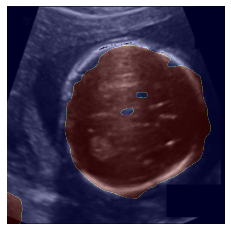

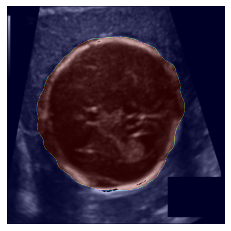

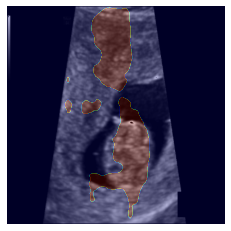

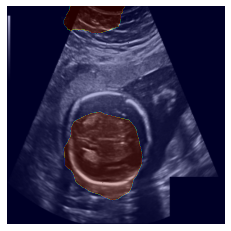

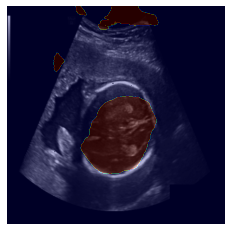

In [24]:
# Looking at outputs

import matplotlib.pyplot as plt

path = '/content/us_dataset'
all_names = os.listdir(os.path.join(path, 'all_images'))

splits = [0.8, 0.1, 0.1]
train_size, val_size, test_size = splits
trn_names, val_names, tst_names = get_splits(all_names, train_size, val_size,
                                              test_size)
_, _, test_loader = get_data_loaders(
    ['train', 'val', 'test'],
    path, [trn_names, val_names, tst_names],
    augment=True,
    aug_prob=0.5,
    batch_size=1
    )

cnt = 0
for batch_num, sample in enumerate(test_loader):
  X, label = sample

  preds = F.softmax(model(X.cuda()), 1) 
  hard_preds = torch.argmax(preds, 1)
  mask = hard_preds[0].detach().cpu().numpy()
  img = X[0].permute(1, 2, 0).numpy()
  img = img.astype('float')
  img = cv2.resize(img, (388, 388))
  img = (img - np.max(img)) / (np.max(img) - np.min(img))

  plt.imshow((img*255).astype('uint8'), cmap='gray')
  plt.imshow(mask, cmap='jet', alpha=0.3)     
#   plt.title('Overlayed Attributions')
  plt.axis('off')
#   plt.colorbar()
  plt.show()                 
  cnt += 1
  if cnt >= 5:
    break